## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [3]:
!pip install torchsummary

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [5]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [6]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [7]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [8]:
len(fmnist_dataset_test)

10000

In [9]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [11]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1, hidden_size=512, dropout_rate=0.2, hidden_size_2=128):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_size, hidden_size_2),
            nn.BatchNorm1d(hidden_size_2),
            nn.ReLU(),
            nn.Linear(hidden_size_2, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [12]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
              ReLU-4                  [-1, 512]               0
           Dropout-5                  [-1, 512]               0
            Linear-6                  [-1, 128]          65,664
       BatchNorm1d-7                  [-1, 128]             256
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 470,154
Trainable params: 470,154
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.79
Estimated Total Size (MB): 1.82
-------------------------------------------

Your experiments come here:

In [14]:
model = TinyNeuralNetwork().to(device)
print(model)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()


# Your experiments, training and validation loops here
num_epochs = 8

train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
              
        outputs = model(images)
        loss = loss_func(outputs, labels)
                
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        epoch_loss += loss.item() * images.size(0)
        
    avg_train_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    
    model.eval()
    correct = 0
    total = 0
    test_loss_epoch = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)
            test_loss_epoch += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_test_loss = test_loss_epoch / len(test_loader.dataset)
    accuracy = 100 * correct / total
    test_losses.append(avg_test_loss)
    test_accuracies.append(accuracy)
    
    clear_output(wait=True)
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {avg_train_loss:.4f}')
    print(f'Test Loss: {avg_test_loss:.4f}, Test Acc: {accuracy:.2f}%')

Epoch [8/8]
Train Loss: 0.2282
Test Loss: 0.3147, Test Acc: 88.45%


# Can't plot, sorry...

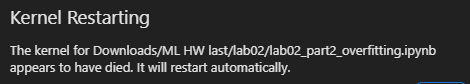

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [18]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1, hidden_size=512, dropout_rate=0.0, hidden_size_2=512):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_size, hidden_size_2),
            nn.ReLU(),
            nn.Linear(hidden_size_2, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [19]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 512]         262,656
              ReLU-6                  [-1, 512]               0
            Linear-7                   [-1, 10]           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.55
Estimated Total Size (MB): 2.58
----------------------------------------------------------------


In [20]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here
num_epochs = 30
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = loss_func(outputs, labels)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        epoch_train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    avg_train_loss = epoch_train_loss / total_train
    train_acc = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)
    
    model.eval()
    correct_test = 0
    total_test = 0
    epoch_test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_func(outputs, labels)
            epoch_test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    avg_test_loss = epoch_test_loss / total_test
    test_acc = 100 * correct_test / total_test
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)
    
    clear_output(wait=True)
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.2f}%')

Epoch [30/30]
Train Loss: 0.0989, Train Acc: 96.18%
Test Loss: 0.4308, Test Acc: 90.00%


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [22]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1, hidden_size=512, dropout_rate=0.5):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_size, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [23]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
              ReLU-4                  [-1, 512]               0
           Dropout-5                  [-1, 512]               0
            Linear-6                   [-1, 10]           5,130
Total params: 408,074
Trainable params: 408,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.56
Estimated Total Size (MB): 1.58
----------------------------------------------------------------


In [24]:
# Урежем трейн, чтобы усилить эффект переобучения и проверить регуляризацию
small_train_dataset, _ = torch.utils.data.random_split(fmnist_dataset_train, [500, len(fmnist_dataset_train)-500])

train_loader = torch.utils.data.DataLoader(small_train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test, batch_size=256, shuffle=False)

In [25]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = loss_func(outputs, labels)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        epoch_loss += loss.item()*images.size(0)
        z, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_train_loss = epoch_loss / total
    train_acc = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}]: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')

model.eval()
correct = 0
total = 0
test_loss = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = loss_func(outputs, labels)
        test_loss += loss.item()*images.size(0)
        
        z, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / total
test_acc = 100 * correct / total
print(f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.2f}%')

Epoch [1/10]: Train Loss: 1.4302, Train Acc: 51.80%
Epoch [2/10]: Train Loss: 0.7825, Train Acc: 73.80%
Epoch [3/10]: Train Loss: 0.6273, Train Acc: 80.80%
Epoch [4/10]: Train Loss: 0.5145, Train Acc: 83.80%
Epoch [5/10]: Train Loss: 0.4578, Train Acc: 85.40%
Epoch [6/10]: Train Loss: 0.3979, Train Acc: 87.80%
Epoch [7/10]: Train Loss: 0.3621, Train Acc: 89.00%
Epoch [8/10]: Train Loss: 0.3021, Train Acc: 89.00%
Epoch [9/10]: Train Loss: 0.2659, Train Acc: 92.60%
Epoch [10/10]: Train Loss: 0.2352, Train Acc: 94.00%
Test Loss: 0.6069, Test Acc: 78.41%


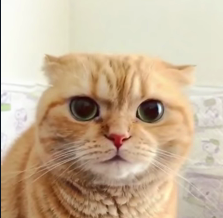

### Conclusions:
_Write down small report with your conclusions and your ideas._